# Проект Телеком
# Постановка задачи:
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать 
отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут 
предложены промокоды и специальные условия. Команда оператора 
собрала персональные данные о некоторых клиентах, информацию об их 
тарифах и договорах.

Целью проекта является подбор модели, которая наилучшим образом предсказывает отток клиентов. В оценке применяется показатель Auc-Roc. В идеале необходимо достичь показателя данной метрики более 0.88 (допустимо от 0.85)

## План проекта

In [146]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 

import lightgbm as lgb
#import xgboost as xgb
from catboost import CatBoostClassifier

In [40]:
try:
    contract = pd.read_csv('C:/project/final/final_provider/contract.csv')
    internet = pd.read_csv('C:/project/final/final_provider/internet.csv')
    personal = pd.read_csv('C:/project/final/final_provider/personal.csv')
    phone = pd.read_csv('C:/project/final/final_provider/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [41]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


Следует отметить, что поле 'TotalCharges' не просто так сохранилось в текстовом формате. Клиенты, начавшие использовать тариф в день закрытия базы (2020-02-01), получили ошибку в этом поле. Исправим ее и поставим значения поля 'TotalCharges' для них равному 'MonthlyCharges', что логично.

In [42]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract[contract['TotalCharges'].isnull()].head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN


In [43]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['MonthlyCharges'])

In [44]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2279.798992
std,30.090047,2266.730170
min,18.250000,18.800000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


In [45]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [46]:
# phone.head(3), phone.info() internet.head(3) internet.info() personal.head(3) personal.info()

### План выполнения проекта

#### Предобработка данных, генерация таргета и новых признаков.
#### Объединение датесетов в один
#### Исследовательский анализ данных, в т.ч. относительно таргета
#### Подготовка признаков датасета к машинному обучению (One-Hot Encoding). 
#### Оценка качества прогноза с помощью кросс-валидации на следующих моделях: RandomForestClassifier, CatBoost, LGBM, выбираем из них лучшую.
#### Для лучшей модели построим ROC-кривую, проведем анализ важности признаков (feature importance), сформулируем выводы (используем тестовую выборку).


## Предобработка данных, генерация таргета и новых признаков.
Данный пункт будет касаться датасета 'contract'. Выше мы уже привели колонку 'TotalCharges' к числовому формату. Также следует обратить внимание, что по двум числовым колонкам выбросов нет (данные укладываются в интервал 3 сигма)
- Сразу бросается в глаза излишняя информация: соотношение 'TotalCharges'/'MonthlyCharges' должно быть равно 'EndDate'(01.02.2020) - 'BeginDate'. Из этих колонок оставим 'MonthlyCharges', посчитаем число месяцев контракта(новая колонка) 
- из колонки 'EndDate' сформируем таргет.

### Формирование новых признаков:

In [47]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [48]:
contract['BeginDate'] =  pd.to_datetime(contract['BeginDate'])
contract['EndDate2020-02-01'] = contract['EndDate'].replace('No', '2020-02-01 00:00:00')
contract['EndDate2020-02-01'] =  pd.to_datetime(contract['EndDate2020-02-01'])
contract['Duration2020-02-01'] = (contract['EndDate2020-02-01']-contract['BeginDate']).astype('timedelta64[D]')
#contract['Duration'] = (contract.TotalCharges/contract.MonthlyCharges).round(2)

Следует отметить,что вариант расчета продолжительности контракта через даты ('Duration2020-02-01') показал гораздо лучшие результаты для машинного обучения, чем расчет этого показателя через соотношение общих и ежемесячных расходов. Возможно, месячные расходы берутся по последнему месяцу (или действующему тарифу), тогда продолжительность считается некорректно.
Попробуем создать дополнительный признак из соотношения MonthlyCharges из таблицы и среднего расчетного(TotalCharges/Duration2020-02-01): 

In [49]:
contract['MonthlyCharges_DIFF'] = contract['MonthlyCharges']/(contract['TotalCharges']/contract['Duration2020-02-01']*30)
#contract['MonthlyCharges_UP'] = (contract['MonthlyCharges'] > (contract['TotalCharges']/contract['Duration2020-02-01'])*30*1.1).astype('int')
#contract['MonthlyCharges_DOWN'] = (contract['MonthlyCharges'] < (contract['TotalCharges']/contract['Duration2020-02-01'])*30*0.9).astype('int')


In [50]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate2020-02-01,Duration2020-02-01,MonthlyCharges_DIFF
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01,31.0,1.033333
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2020-02-01,1036.0,1.040843
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61.0,1.012436


In [51]:
contract = contract.drop(columns=['BeginDate','TotalCharges', 'EndDate2020-02-01'])

### Формирование Target

In [52]:
contract['Target'] = contract.EndDate.apply(lambda x: 0 if x=='No' else 1)

In [53]:
contract = contract.drop(columns='EndDate')
contract.head(3)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Duration2020-02-01,MonthlyCharges_DIFF,Target
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.0,1.033333,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1036.0,1.040843,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,61.0,1.012436,1


## Объединение датесетов в один
- Датасеты 'contract' и 'personal' содержат одинаковое количество записей. Логично предположить, что все записи должны совпасть. Сделаем тип объединения 'inner' чтобы убедиться в этом.
- Остальные 2 датасета содержат меньшее количество записей. При объединении (left) должны образоваться пропуски, которые можно закрыть заглушкой 'not_using' (для 'InternetService'), 'No' - для остальных колонок.

In [54]:
data = contract.merge(personal, on='customerID', how='inner')

In [55]:
data.shape # 7043 записи, ничего не пропало

(7043, 12)

In [56]:
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

In [57]:
data = data.drop(columns='customerID')
data['InternetService'] = data.InternetService.fillna('not_using')
data = data.fillna('No')

In [58]:
data.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Duration2020-02-01,MonthlyCharges_DIFF,Target,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,31.0,1.033333,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,56.95,1036.0,1.040843,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,61.0,1.012436,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 7043 non-null   object 
 1   PaperlessBilling     7043 non-null   object 
 2   PaymentMethod        7043 non-null   object 
 3   MonthlyCharges       7043 non-null   float64
 4   Duration2020-02-01   7043 non-null   float64
 5   MonthlyCharges_DIFF  7043 non-null   float64
 6   Target               7043 non-null   int64  
 7   gender               7043 non-null   object 
 8   SeniorCitizen        7043 non-null   int64  
 9   Partner              7043 non-null   object 
 10  Dependents           7043 non-null   object 
 11  InternetService      7043 non-null   object 
 12  OnlineSecurity       7043 non-null   object 
 13  OnlineBackup         7043 non-null   object 
 14  DeviceProtection     7043 non-null   object 
 15  TechSupport          7043 non-null   o

Проверим наличие ошибок в текстовых полях (разные написания одинаковых значений)

In [60]:
for column in data.select_dtypes(object).columns:
    print(data[column].unique())

['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
['DSL' 'Fiber optic' 'not_using']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


## Исследовательский анализ данных

### Анализ корреляции
Так как мы не используем линейные модели, то большой потребности в этом этапе нет. Тем не менее, всегда интересно посмотреть, есть ли какая-то связь внутри признаков.

#### Проведем анализ корреляции численных признаков (коэф. Пирсона)

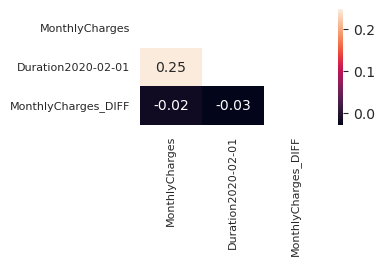

In [142]:
pir_overview = data[['MonthlyCharges', 'Duration2020-02-01', 'MonthlyCharges_DIFF']].corr()

mask = np.zeros_like(pir_overview)
mask[np.triu_indices_from(pir_overview)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(3, 1.5))
    ax = sns.heatmap(pir_overview, annot=True, mask=mask, fmt='.2f', cbar_kws={"orientation": "vertical"})
    ax.tick_params(labelsize=8)

#### Посчитаем корреляцию Крамера для категориальных данных:

In [62]:
def cramers_corrected_stat(column1, column2):
    matrix = pd.crosstab(column1, column2)
    chi2 = ss.chi2_contingency(matrix)[0]
    n = matrix.sum().sum()
    phi2 = chi2/n
    r,k = matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [63]:
cramers = pd.DataFrame(index=list(data.select_dtypes(object).columns))
for column in data.select_dtypes(object).columns:
    temp = []
    for col in data.select_dtypes(object).columns:
        temp.append(cramers_corrected_stat(data[column], data[col]))
    cramers[column] = temp   

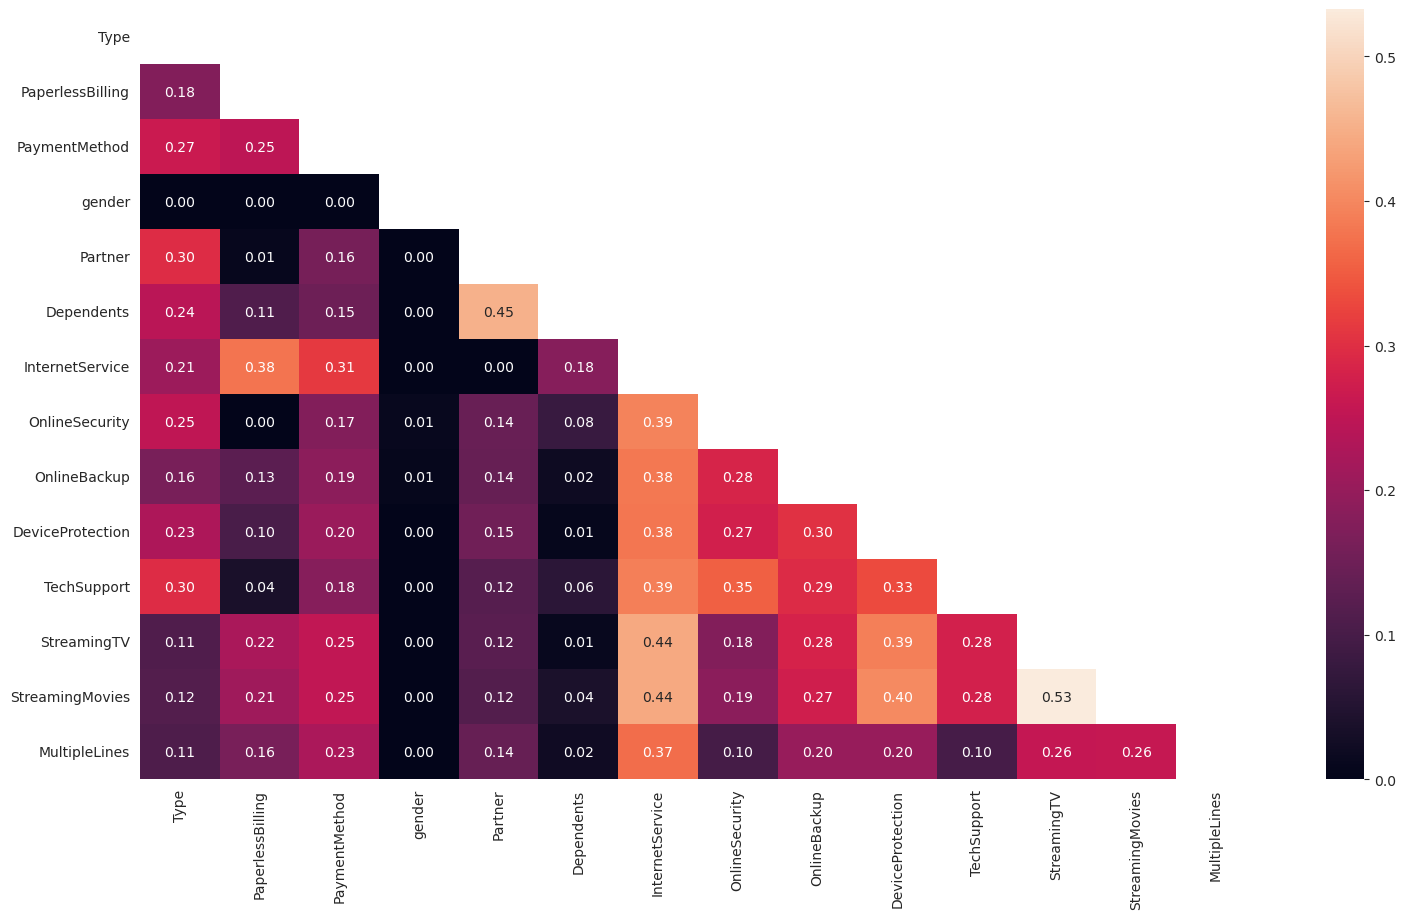

In [64]:
mask = np.zeros_like(cramers)
mask[np.triu_indices_from(cramers)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 10))
    ax = sns.heatmap(cramers, annot=True, mask=mask, fmt='.2f', cbar_kws={"orientation": "vertical"})

Можно отметить, что относительно высокая корреляция наблюдается между признаками StreamingTV и StreamingMovies, что логично.

### Баланс классов
Следует отметить, что текущих пользователей примерно в три раза больше, чем отказавшихся.

In [65]:
data['Target'].value_counts()

0    5174
1    1869
Name: Target, dtype: int64

Если бы модель предсказывала '0' во всех случаях, то Accuracy составил бы 0.73. На этот параметр тоже необходимо ориентироваться при оценке показателей лучшей модели. 

In [66]:
data['Target'].value_counts()[0]/data['Target'].value_counts().sum()

0.7346301292063041

### Распределение числовых признаков относительно таргета

(0.0, 150.0)

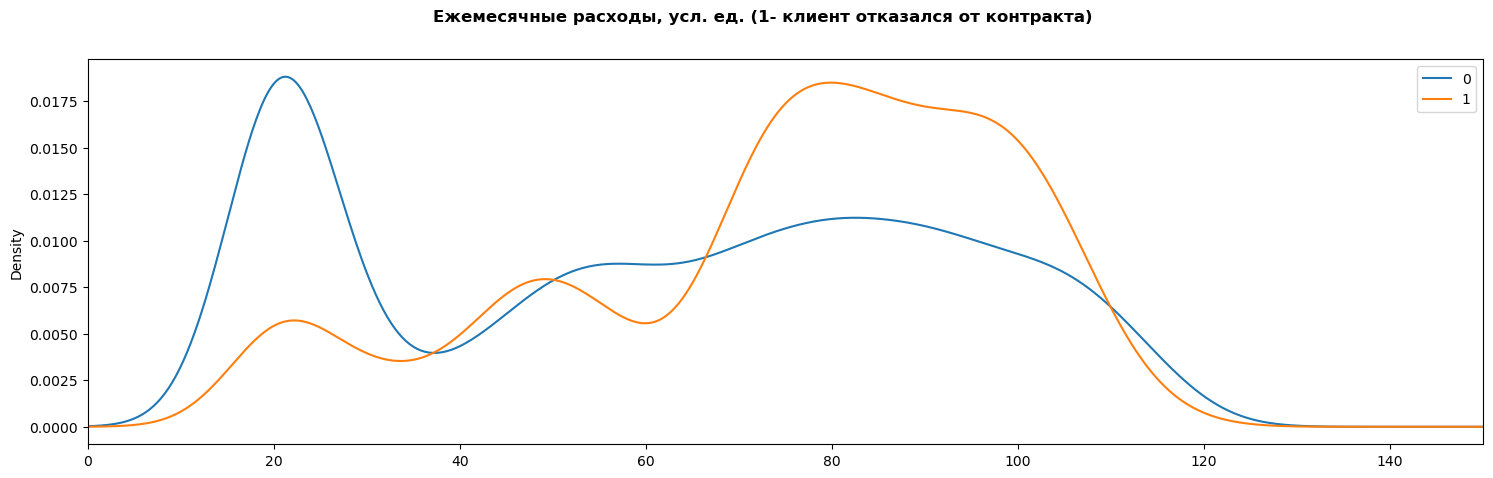

In [67]:
fig, ax = plt.subplots(1,1, figsize=(18, 5)) 
fig.suptitle('Ежемесячные расходы, усл. ед. (1- клиент отказался от контракта)', fontweight ="bold")
for target, group_data in data.groupby('Target'):
    group_data['MonthlyCharges'].plot(kind='kde', legend=True, label=target, ax=ax)
ax.set_xlim(0, 150)

Существует повышенная вероятность отказа от контракта для клиентов с высокими ежемесячными расходами (от 70 усл. единиц). 

(0.0, 3000.0)

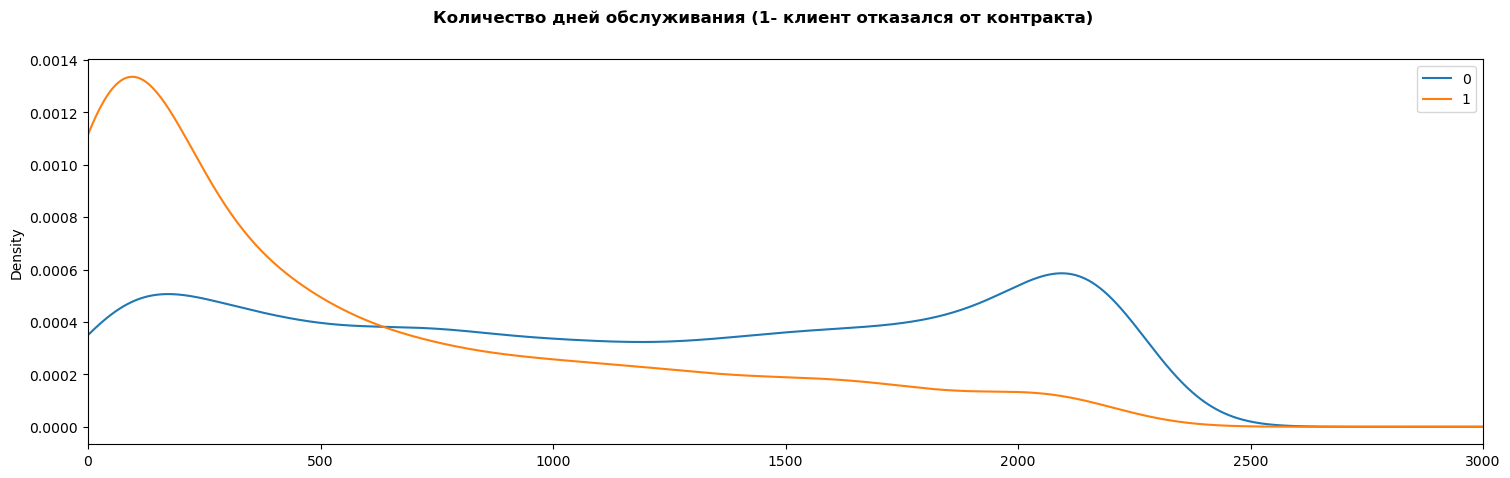

In [68]:
fig, ax = plt.subplots(1,1, figsize=(18, 5)) 
fig.suptitle('Количество дней обслуживания (1- клиент отказался от контракта)', fontweight ="bold")
for target, group_data in data.groupby('Target'):
    group_data['Duration2020-02-01'].plot(kind='kde', legend=True, label=target, ax=ax)
ax.set_xlim(0, 3000)

Существует повышенная вероятность отказа от контракта в первый год его использования. 

(0.95, 1.1)

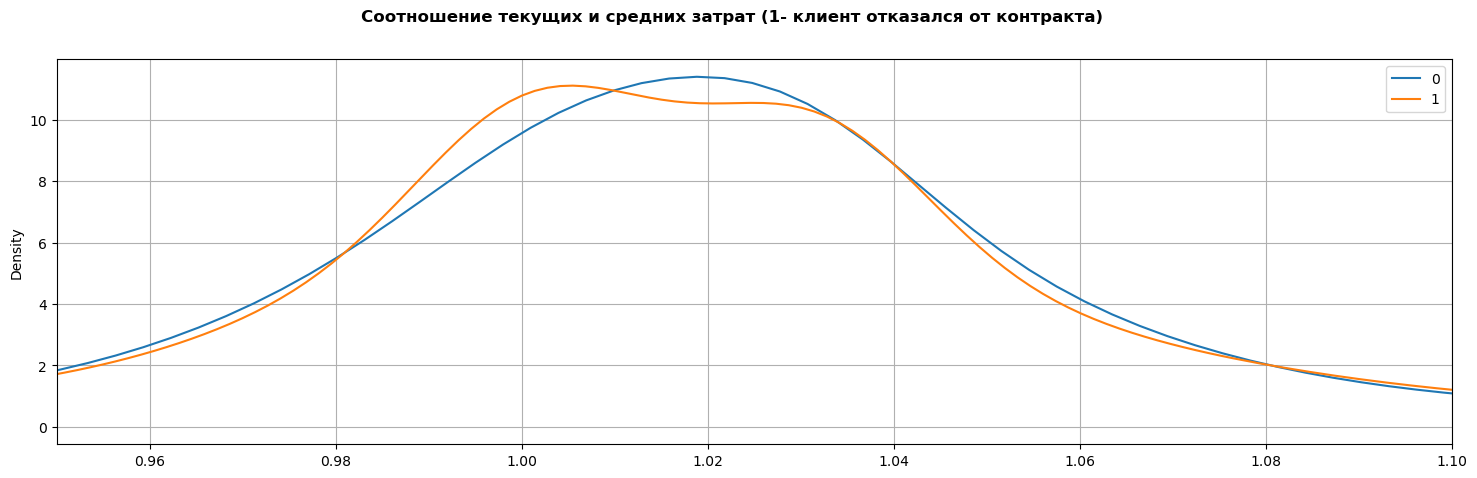

In [124]:
fig, ax = plt.subplots(1,1, figsize=(18, 5)) 
fig.suptitle('Соотношение текущих и средних затрат (1- клиент отказался от контракта)', fontweight ="bold")
for target, group_data in data.groupby('Target'):
    group_data['MonthlyCharges_DIFF'].plot(kind='kde', legend=True, label=target, ax=ax, grid=True)
ax.set_xlim(0.95, 1.1)

Следует отметить, что распределения практически идентичные. Можно отметить небольшое смещение с сторону единицы для тех, кто отказался от контракта, но это больше похоже на ошибку округления (считали, что в среднем в месяце 30 дней)

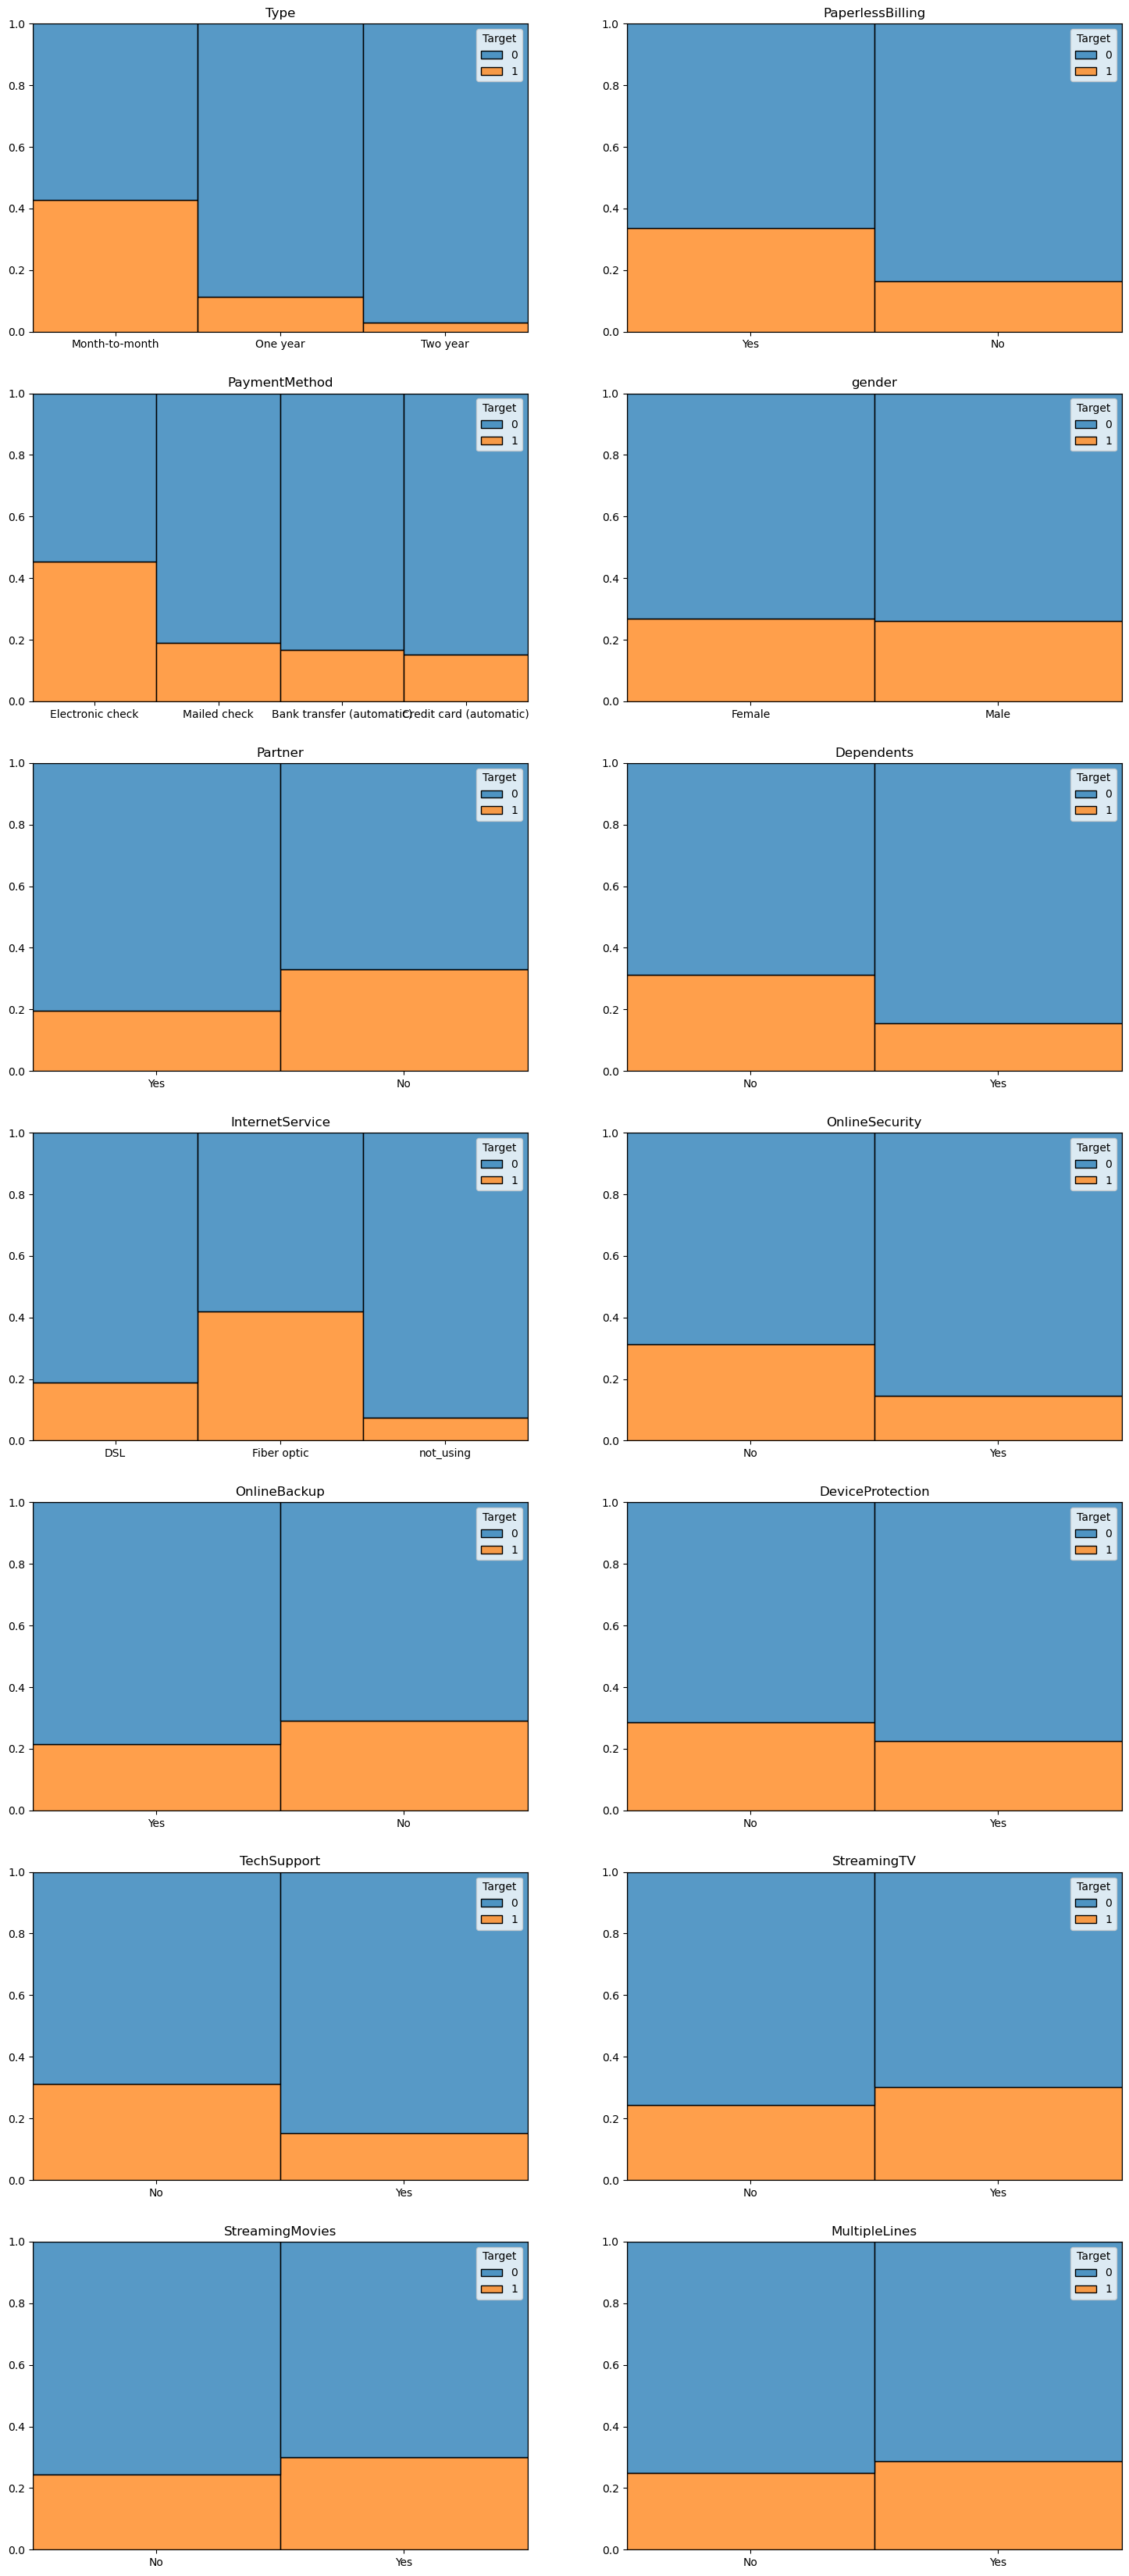

In [69]:
ax = {}
fig = plt.figure(figsize=(18,42))
#fig.suptitle(r'Распределение признаков по таргету, 1-клиент отказался от контракта', fontweight ="bold")
for i,j in enumerate(data.select_dtypes(object).columns):
    ax[i] = plt.subplot(math.ceil(len(data.select_dtypes(object).columns)/2),2,i+1)
    sns.histplot(data=data, x=j, hue="Target", multiple="fill", stat='probability')
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(j)

Сразу можно отметить важные категориальные признаки(большой разброс по долям ушедших и оставшихся клиентов): Type(тип оплаты), PapelessBilling, PaymentMethod, IndernetService, OnlineSecurity, TechSupport.

## Подготовка признаков датасета к машинному обучению (One-Hot Encoding)

### Выделим features и target, разобъем выборку на train и test

In [70]:
features = data.drop(columns=['Target']) # 'StreamingMovies'
target = data['Target']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=171022)
features_train = features_train.reset_index(drop=True) #сбрасываем индексы для дальнейшего формирования датасета 
# после OneHotEncoder
features_test = features_test.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

### Преобразуем features методом прямого кодирования (One-Hot-Encoding)

In [71]:
transformer = make_column_transformer(
    (OneHotEncoder(drop ='first'), 
     data.select_dtypes(include='object').columns), remainder='passthrough', verbose_feature_names_out=False)
# remainder='passthrough' оставляет колонки, не участвующие в предбразовании
# verbose_feature_names_out=False - новый параметр, позволяет оставить старые названия колонок по типу pd.get_dummies(),
#что удобно для дальнейшего анализа

In [72]:
transformed_train = transformer.fit_transform(features_train)
features_train_ohe = pd.DataFrame(transformed_train, columns=transformer.get_feature_names_out())

transformed_test = transformer.transform(features_test)
features_test_ohe = pd.DataFrame(transformed_test, columns=transformer.get_feature_names_out())

### Прозведем масштабирование числовых признаков.
При тех моделях, которое были выбраны, этот шаг не является обязательным.

In [75]:
numeric = ['MonthlyCharges', 'Duration2020-02-01']
scaler = StandardScaler()

features_train_ohe[numeric] = scaler.fit_transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

## Оценка качества прогноза с помощью кросс-валидации на следующих моделях: RandomForestClassifier, CatBoost, LGBM

### RandomForestClassifier

In [76]:
%%time
model = RandomForestClassifier(random_state=171022)
param_grid={
             'n_estimators':np.arange(200,610,100), #'class_weight':[None, 'balanced']
             'max_depth':np.arange(6,16,3)
}

grid = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid.fit(features_train_ohe, target_train)

CPU times: total: 4.27 s
Wall time: 1min 39s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=171022),
             n_jobs=-1,
             param_grid={'max_depth': array([ 6,  9, 12, 15]),
                         'n_estimators': array([200, 300, 400, 500, 600])},
             scoring='roc_auc')

In [77]:
grid.best_params_

{'max_depth': 9, 'n_estimators': 500}

In [78]:
grid.best_score_ 

0.8566461216270269

#### RandomForestClassifier дал очень неплохой результат: roc_auc = 0.857 при следующих гиперпараметрах модели
- {'max_depth': 9, 'n_estimators': 500}

### LGBMClassifier

In [98]:
%%time
model = lgb.LGBMClassifier(random_state=171022)
param_grid={ 'learning_rate':[0.15, 0.2, 0.3],  #'class_weight':[None, 'balanced'] [0.015, 0.02, 0.03]
             'n_estimators':np.arange(700,910,100),
             'num_leaves':np.arange(2,9,2)
             #'min_data_in_leaf': np.arange(50,105,25 )
}

grid_lgb = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_lgb.fit(features_train_ohe, target_train)

CPU times: total: 1.91 s
Wall time: 34.2 s


GridSearchCV(cv=4, estimator=LGBMClassifier(random_state=171022), n_jobs=-1,
             param_grid={'learning_rate': [0.15, 0.2, 0.3],
                         'n_estimators': array([700, 800, 900]),
                         'num_leaves': array([2, 4, 6, 8])},
             scoring='roc_auc')

In [99]:
grid_lgb.best_params_

{'learning_rate': 0.2, 'n_estimators': 800, 'num_leaves': 4}

In [100]:
grid_lgb.best_score_

0.902813014900332

#### Использование модели LGBMClassifier существенно улучшило результат : roc_auc = 0.902 при следующих гиперпараметрах 
- {'learning_rate': 0.2, 'n_estimators': 800, 'num_leaves': 4}

  ### CatBoostClassifier

In [108]:
%%time
model = CatBoostClassifier(loss_function="Logloss", random_state=171022, silent=True) #verbose=False
param_grid={ 'learning_rate':[0.5, 0.6, 0.7],
             'depth':[1,2,3],
             'iterations':[500,600,700]
}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features_train_ohe, target_train)

CPU times: total: 4.25 s
Wall time: 1min 28s


GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001FF14B28DC0>,
             n_jobs=-1,
             param_grid={'depth': [1, 2, 3], 'iterations': [500, 600, 700],
                         'learning_rate': [0.5, 0.6, 0.7]},
             scoring='roc_auc')

In [109]:
grid_CatBoost.best_params_

{'depth': 2, 'iterations': 600, 'learning_rate': 0.6}

In [110]:
grid_CatBoost.best_score_

0.9234124697261448

#### Моделью с лучшим показателем стала CatBoostClassifier: roc_auc = 0.923 при следующих гиперпараметрах 
- {'depth': 2, 'iterations': 600, 'learning_rate': 0.6}

## Оценка качества прогноза на тестовой выборке для лучшей модели

### Roc-кривая

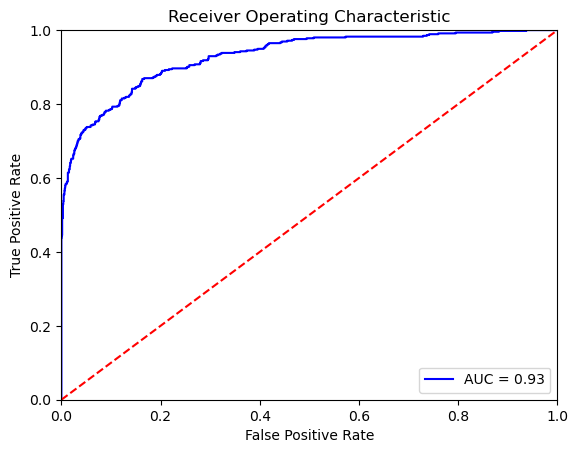

In [125]:
probabilities = grid_CatBoost.predict_proba(features_test_ohe)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities)
roc_auc = roc_auc_score(target_test, probabilities)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Метрика roc_auc на тестовой выборке показала даже чуть лучший результат, чем на кросс-валидации: 0.93

### Accuracy

In [112]:
predictions = grid_CatBoost.predict(features_test_ohe)
accuracy_score(target_test, predictions)

0.8960817717206133

Значение метрики Accuracy составило 0.89. Данное значение можно сравнить со значением константной модели (модель всегда прогнозируеет значение наибольшего класса)
- В п. 4.2 Accuracy на константной модели составило 0.73.
- Можно сделать вывод, что выбранная модель машинного обучения существенно превосходит константную модель для представленных данных и рекомендуется для использовании в прогнозировании.

### Оценка важности признаков для модели

In [113]:
feature_importances = pd.DataFrame(
    {'Feature':features_train_ohe.columns, 'Est': grid_CatBoost.best_estimator_.feature_importances_},
    ).sort_values(by='Est', ascending=False).reset_index(drop=True)

feat = pd.DataFrame({'Feature_name':features.select_dtypes(object).columns}).reset_index()

In [116]:
feature_importances.head(6)

,Feature,Est
0,Duration2020-02-01,68.900288
1,MonthlyCharges_DIFF,7.747851
2,MonthlyCharges,6.932025
3,Type_Two year,4.900331
4,InternetService_Fiber optic,4.315109
5,InternetService_not_using,1.544194


Можно отметить, что Топ-5 признаков по важности для модели хорошо объяснимы:
 - Duration и MonthlyCharges мы отмечали еще в Исследовательском анализе данных
 - Удивительно хорошо показал себя новый признак: MonthlyCharges_DIFF (разница в текущих затратах и средних за весь период). Хотя, как мы отмечали раньше, это может быть связано с ошибкой округления.
 - Тип оплаты (Two year, One year) явно говорит, что пользователь не хочет отказываться от услуг
 - Fiber optic/Internet_not_using, замена оператора влечет значительные временные затраты для пользователя